# Training

In [1]:
import torch
import random
import numpy as np

# from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import json

from matplotlib import pyplot as plt

from ipynb.fs.full.read_in_data import read_in_data
from validation import predict


from transforms import train_transforms, val_transforms
from dataset import ContrastiveLearningDataset, SimpleDataset

/home/aleksandra/Documents/hackathon/knum_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading data

In [2]:
with open("../public_dataset/reference_images_part1.json") as f:
    ref_json = json.load(f)

dir_str = "../public_dataset/reference_images_part1"
df = read_in_data(dir_str, ref_json)

df = df.sort_values('category_id')
df = df.reset_index(drop=True)
df.head()

,id,image_id,bbox,category_id,img
0,155,33,"[116, 97, 411, 126]",1,<PIL.Image.Image image mode=RGB size=411x126 a...
1,33,6,"[573, 246, 164, 298]",1,<PIL.Image.Image image mode=RGB size=164x298 a...
2,32,6,"[114, 269, 363, 223]",1,<PIL.Image.Image image mode=RGB size=363x223 a...
3,30,6,"[622, 218, 374, 220]",1,<PIL.Image.Image image mode=RGB size=374x220 a...
4,29,6,"[743, 486, 354, 132]",1,<PIL.Image.Image image mode=RGB size=354x132 a...


In [3]:
from torchvision.transforms import transforms as T

1
torch.Size([3, 224, 224])


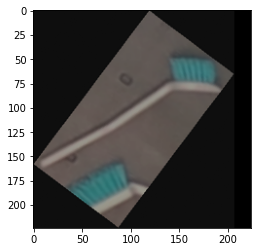

In [4]:
id = 1
img = df['img'][id]
print(df['category_id'][id])

img = train_transforms(img)

print(img.shape)

plt.imshow(img.permute(1, 2, 0))

In [5]:
images = df['img']
labels = df['category_id']

val_labels = [4, 5, 6]
val_ids = ~labels.isin(val_labels) # TODO

val_images = images[val_ids].reset_index(drop=True)
val_labels = labels[val_ids].reset_index(drop=True)

train_ids = ~val_ids

train_images = images[train_ids].reset_index(drop=True)
train_labels = labels[train_ids].reset_index(drop=True)

In [6]:
train_dataset = ContrastiveLearningDataset(train_images, train_labels, train_transforms)
val_dataset = SimpleDataset(train_images, train_labels, val_transforms)

In [7]:
id_ = random.randrange(0, len(train_dataset))

image, label = train_dataset[id_]

# f, axarr = plt.subplots(1,2) 

# axarr[0].imshow(image_1.permute(1, 2, 0))
# axarr[1].imshow(image_2.permute(1, 2, 0))

# sign, weight

print(image.mean(), image.max(), image.min())

tensor(0.5305) tensor(1.) tensor(0.)


In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [9]:
BATCH_SIZE = 8

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=False,
)

## Training loop

In [10]:
EPOCHS = 100

In [11]:
from ipynb.fs.full.fb_model_extractor import DeiTForImageClassificationWithTeacher
from transformers import AutoFeatureExtractor

torch.Size([1, 384])


In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/deit-small-distilled-patch16-224') # TODO to nie jest dotrenowywane
model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-small-distilled-patch16-224')
optimizer = torch.optim.Adam(model.parameters())

In [13]:
from losses import ContrastiveLoss, CosineSimilarityLoss

loss_function = CosineSimilarityLoss(pos_weight=3)
# loss_function = ContrastiveLoss(np.sqrt(out_dim))
# loss_function2 = ContrastiveLoss(np.sqrt(out_dim), reduction="NONE")
# cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# def contrastive_learning_loss(v_1, v_2, weight, sign):
#     cos_sim = cos(v_1, v_2)
#     loss = - weight * cos_sim * sign
#     return loss.mean()



In [14]:
from sklearn.decomposition import PCA

def validate(model, dataset):
    embeddings = []
    labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.to(device=DEVICE)
        label = label
        emb = model(**feature_extractor(image.cpu(), return_tensors='pt'))
        embeddings.append(emb[0].detach().cpu().numpy())
        labels.append(label)

    emb4lab_dict = {}
    for e, l in zip(embeddings, labels):
        if l not in emb4lab_dict.keys():
            emb4lab_dict[l] = [e]
        else:
            emb4lab_dict[l].append(e)
    for l in emb4lab_dict.keys():
        emb4lab_dict[l] = np.mean(np.array(emb4lab_dict[l]), axis=0)
    
    lbl_dsts = {}
    for e, l in zip(embeddings, labels):
        dst = np.sum(np.abs(e - emb4lab_dict[l]))
        if l not in lbl_dsts.keys():
            lbl_dsts[l] = [dst]
        else:
            lbl_dsts[l].append(dst)
    for l in lbl_dsts.keys():
        lbl_dsts[l] = np.mean(np.array(lbl_dsts[l]), axis=0)
        print(f"LABEL: {l} - MEAN DST: {lbl_dsts[l]}")
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    
    pca = PCA()
    pca.fit(embeddings)
    emb2d = pca.transform(embeddings)
    plt.scatter(emb2d[:,0], emb2d[:,1], c=labels)
    plt.show()

In [15]:
# with open("../public_dataset/images_part1_valid.json") as f:
#     ref_json = json.load(f)

# dir_str = "../public_dataset/images_part1_valid"
# valid_data = read_in_data(dir_str, ref_json)

# with open("../public_dataset/reference_images_part1.json") as f:
#     ref_json = json.load(f)

# dir_str = "../public_dataset/reference_images_part1"
# ref_data = read_in_data(dir_str, ref_json)

In [16]:
# df = predict(model, ref_data, valid_data, feature_extractor)
# accuracy = (df.pred_category == df.category_id).mean()
# print(accuracy)

<class 'torch.Tensor'>


ValueError: Expected a 1D array, got an array with shape (144, 384)

In [ ]:
torch.cuda.empty_cache()
LOSS_COUNT_SAMPLES = 24

validate(model, val_dataset)
optimizer.zero_grad()
for epoch in range(EPOCHS):
    losses = []
    all_labels = []
    all_ys = []
    for i, data in enumerate(train_loader, 0):
        torch.cuda.empty_cache()
        images, labels = data
        images = images.to(device=DEVICE)
        images = [np.array(image.cpu(), dtype=np.uint8) for image in images]
        
        ys = model(**feature_extractor(images, return_tensors='pt'))
        
        all_ys.append(ys)
        all_labels.append(labels)
        
        if (i+1) % (LOSS_COUNT_SAMPLES // BATCH_SIZE) == 0:
            loss = loss_function(torch.cat(all_ys), torch.cat(all_labels))
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())
            all_ys = []
            all_labels = []
            optimizer.zero_grad()
        
    total_loss = np.mean(losses)
    print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
    if epoch % 5 == 0:
        validate(model, val_dataset)
    
        # YOUR CODE HERE
        
        # TODO: walidacja, wypisywanie lossów itd
        # END YOUR CODE

In [ ]:
# for epoch in range(EPOCHS):
#     if epoch == 3:
#         optimizer = torch.optim.Adam(model.get_backbone_params())
#     losses = []
#     for i, data in enumerate(train_loader, 0):
#         image_1, image_2, sign, weight = data
#         image_1 = image_1.to(device=DEVICE)
#         image_2 = image_2.to(device=DEVICE)
#         sign = sign.to(device=DEVICE)
#         weight = None # weight.to(device=DEVICE)

#         optimizer.zero_grad()
        
#         v_1 = model(image_1)
#         v_2 = model(image_2)
        
#         loss = loss_function(v_1, v_2, sign, weight=weight)
#         # loss2 = loss_function2(v_1, v_2, sign, weight=weight)
        
#         # print(sign)
#         # print(weight)
#         # print(loss2)
        
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.cpu().item())
#         if i % 10 == 0:
#             print(f"i: {i}: {loss}")
        
#     total_loss = np.mean(losses)
#     print(f"Epoch: {epoch + 1}/{EPOCHS}: Loss: {total_loss}")
#     validate(model, val_dataset)
#         # YOUR CODE HERE
        
#         # TODO: walidacja, wypisywanie lossów itd
#         # END YOUR CODE